In [40]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [41]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

641.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


647.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


653.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


# Dataset

In [42]:
import torch
from torch_geometric.datasets import Planetoid
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/actor.html#Actor
dataset = Planetoid(root='.', name="Pubmed")
# dataset = Planetoid(root='.', name="Cora")


# dataset= KarateClub()
data = dataset[0] 

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}') 
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')


print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Mini-batching

Subgraph 0: Data(x=[414, 500], edge_index=[2, 458], y=[414], train_mask=[414], val_mask=[414], test_mask=[414], n_id=[414], e_id=[458], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[267, 500], edge_index=[2, 318], y=[267], train_mask=[267], val_mask=[267], test_mask=[267], n_id=[267], e_id=[318], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[293, 500], edge_index=[2, 334], y=[293], train_mask=[293], val_mask=[293], test_mask=[293], n_id=[293], e_id=[334], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[190, 500], edge_index=[2, 232], y=[190], train_mask=[190], val_mask=[190], test_mask=[190], n_id=[190], e_id=[232], input_id=[12], batch_size=12)


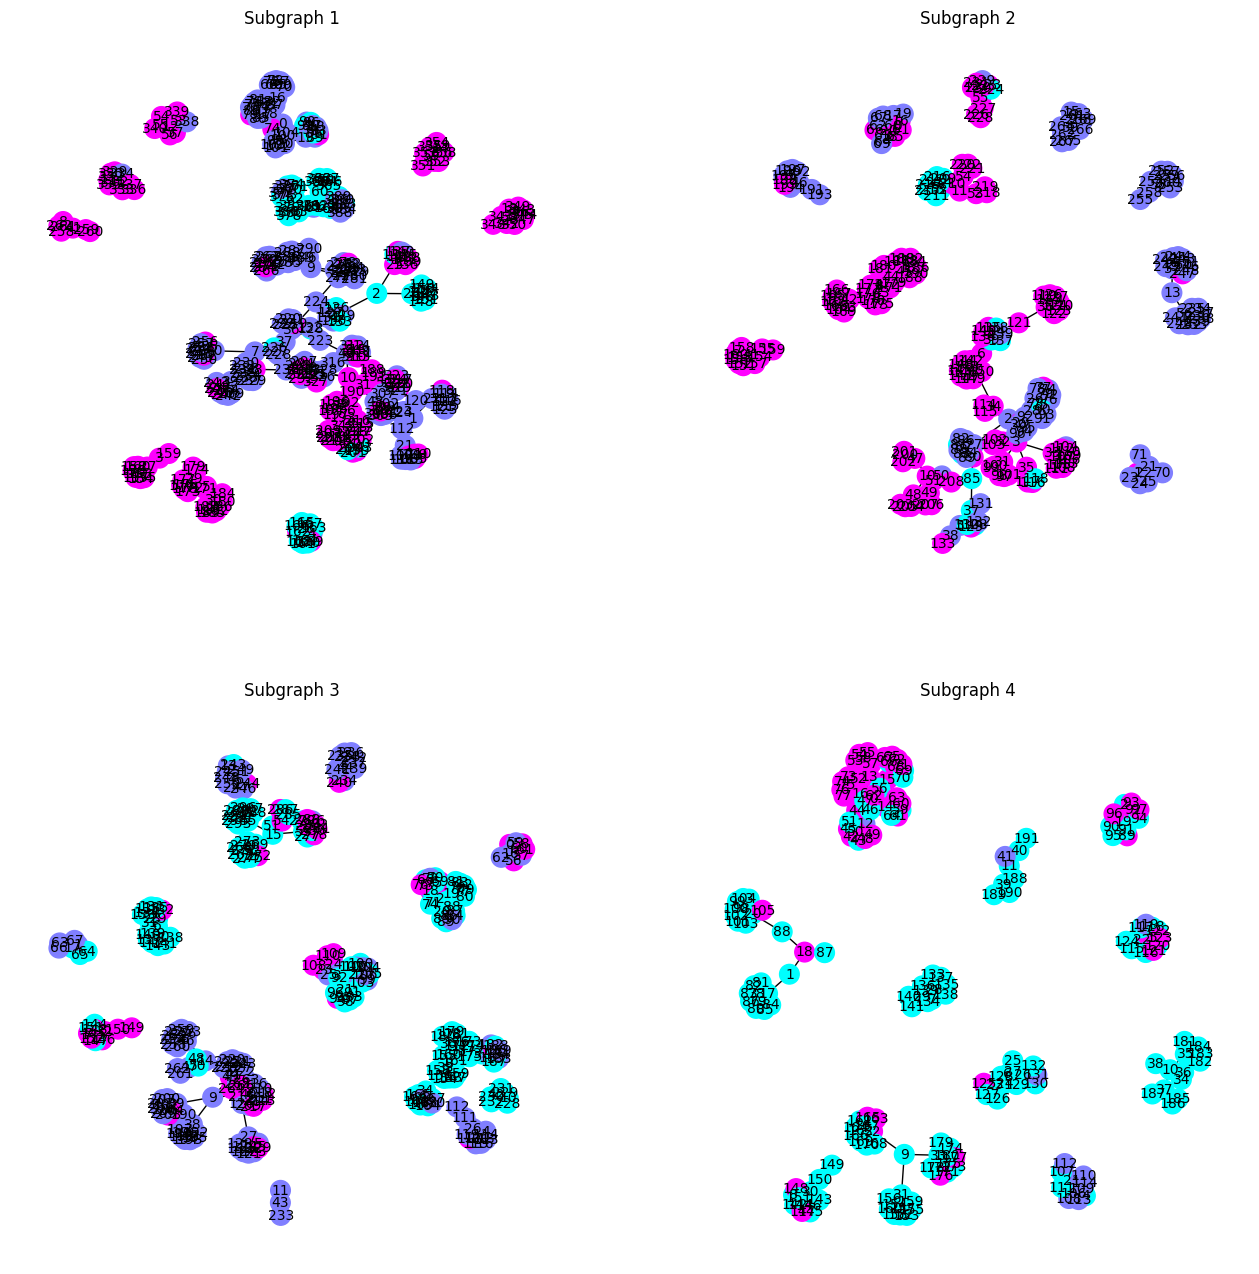

In [43]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))


for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx+1}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )



# Dataset Graph

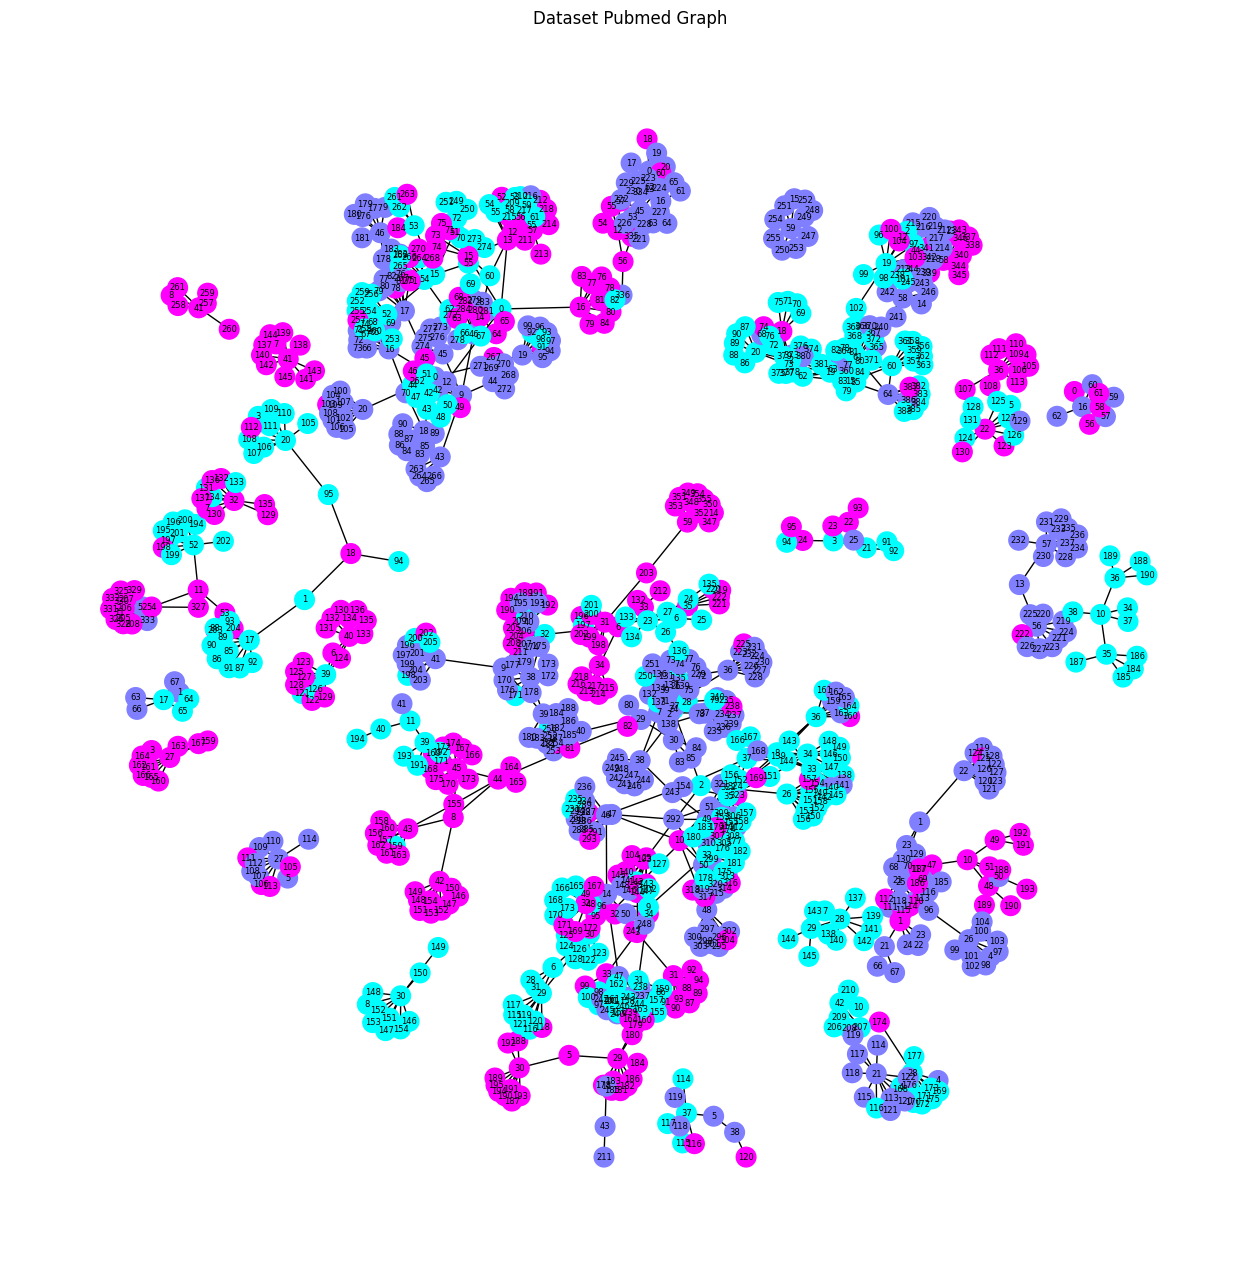

In [44]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

plt.figure(figsize=(16, 16))


for idx, subdata in enumerate(train_loader):
    G = to_networkx(subdata, to_undirected=True)  
    pos = nx.spring_layout(G, seed=0) 
    nx.draw_networkx(G,
                     pos=pos,
                     with_labels=True,
                     node_size=200,
                     node_color=subdata.y,
                     cmap='cool',
                     font_size=6,
                     label=f'Subgraph {idx}') 

plt.title(f'Dataset {dataset.name} Graph') 
plt.axis('off')  
plt.show()  


# Plot node degrees

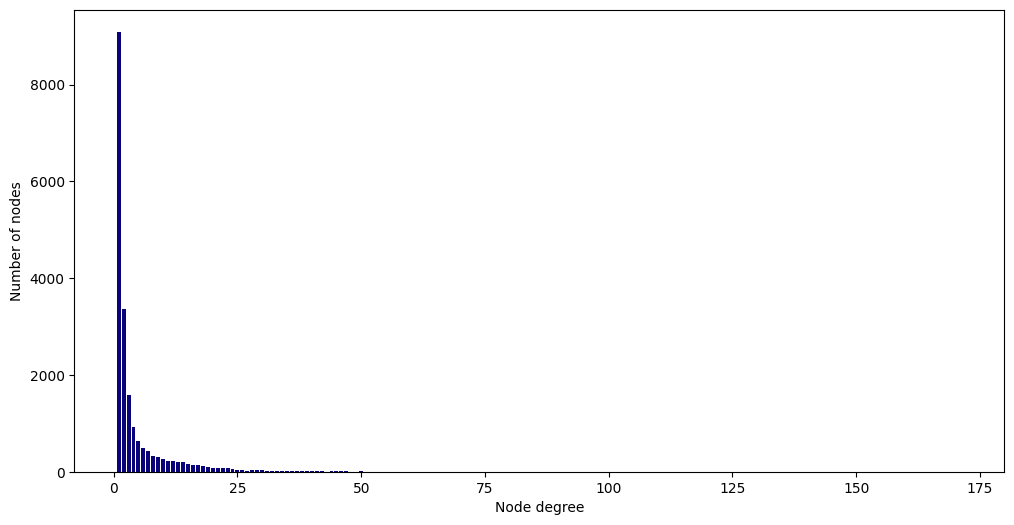

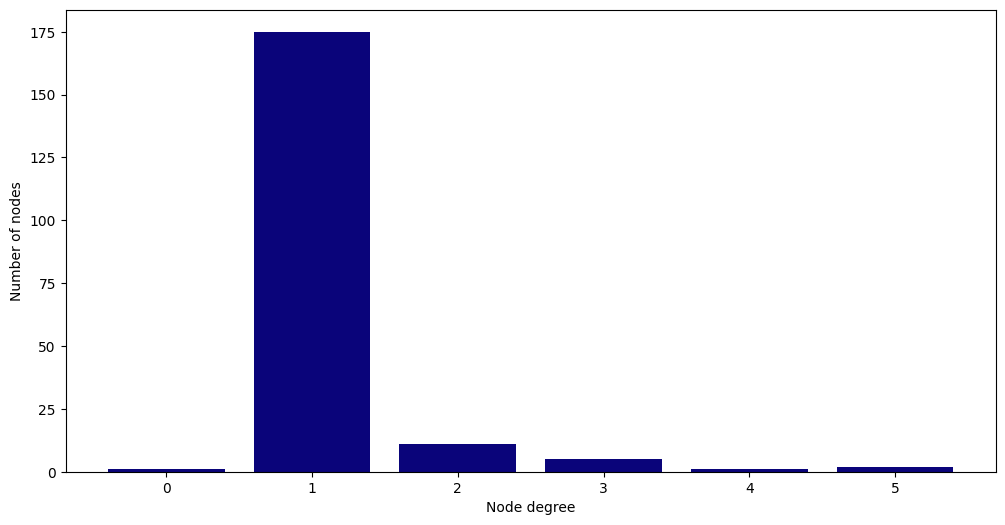

In [45]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Implement GraphSage

In [46]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)
  '''
  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')
     '''     
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc
   

# Train GraphSAGE

In [47]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)


AttributeError: 'GraphSAGE' object has no attribute 'fit'

# Vector

In [48]:
from sklearn.manifold import TSNE

In [53]:
# Instantiate the model, define the optimizer and the loss function
model = GraphSAGE(dataset.num_features, 64, 16) # Reduce the output dimension to 16 for visualization 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        
        # Ensure the train_mask is boolean
        train_mask = batch.train_mask
        if train_mask.dtype != torch.bool:
            train_mask = train_mask.bool()
        
        # Compute the loss
        loss = criterion(out[train_mask], batch.y[train_mask])
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1
    return total_loss / batch_count

# Train the model
for epoch in range(200):  # Adjust the number of epochs as needed
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Get the node embeddings
model.eval() 
with torch.no_grad(): 
    embeddings = model(data.x, data.edge_index) 

# Visualize the node embeddings using t-SNE
tsne = TSNE(n_components=2) # Reduce the dimensionality to 2
embeddings_2d = tsne.fit_transform(embeddings.numpy()) 

plt.figure(figsize=(10, 10)) 
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.numpy(), cmap='cool', s=20) 
plt.colorbar()
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()

TypeError: unsupported format string passed to GraphSAGE.__format__